Dataset Shape: (3000, 2)

Class Distribution:
Liked
0    0.5
1    0.5
Name: proportion, dtype: float64

Model Evaluation:
Training Accuracy: 0.8790476190476191
Validation Accuracy: 0.77
Test Accuracy: 0.8033333333333333

Classification Report (Validation Set):
              precision    recall  f1-score   support

           0       0.76      0.78      0.77       150
           1       0.78      0.76      0.77       150

    accuracy                           0.77       300
   macro avg       0.77      0.77      0.77       300
weighted avg       0.77      0.77      0.77       300


Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.81      0.80      0.80       300
           1       0.80      0.81      0.80       300

    accuracy                           0.80       600
   macro avg       0.80      0.80      0.80       600
weighted avg       0.80      0.80      0.80       600



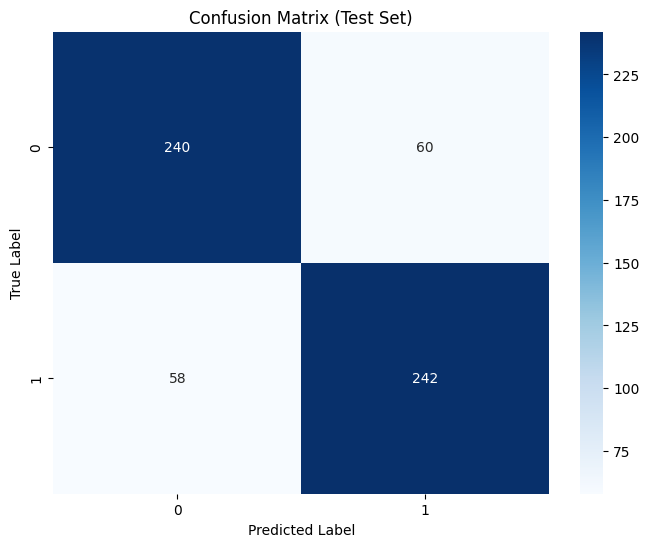


Analyzing Feature Importance:


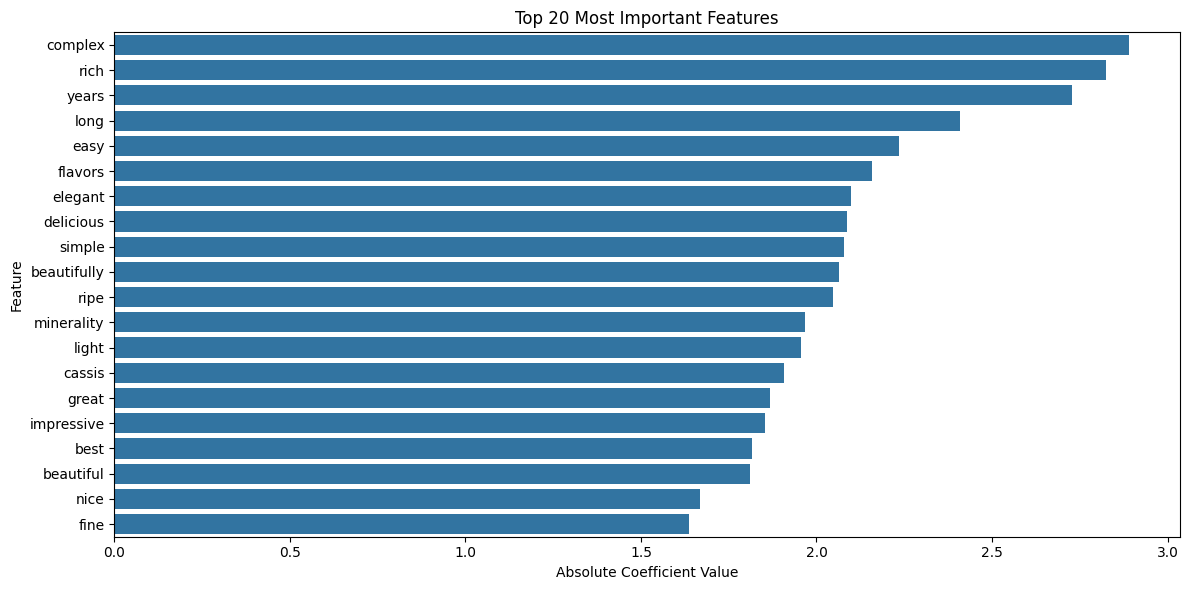


Example Predictions:

Review: An excellent wine with great balance and complexity. Rich flavors of dark fruit and oak.
Prediction: Liked
Probability: Positive=0.859, Negative=0.141

Review: Simple and straightforward. Somewhat bland with little character.
Prediction: Not Liked
Probability: Positive=0.049, Negative=0.951

Review: Amazing depth with perfect tannins. A masterpiece of winemaking.
Prediction: Not Liked
Probability: Positive=0.470, Negative=0.530


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

def load_and_prepare_data(file_path):
    df = pd.read_csv(file_path)

    df = df[['description', 'points']]

    df['sentiment'] = df['points'].apply(lambda x: 1 if x >= 90 else 0)

    df = df.drop('points', axis=1)

    df.columns = ['Review', 'Liked']

    return df

def preprocess_text(text):
    text = str(text)
    text = text.lower()
    return text

def create_baseline_model(df, val_size=0.1, test_size=0.2, random_state=42):
    df['Review'] = df['Review'].apply(preprocess_text)

    X = df['Review']
    y = df['Liked']

    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=val_size/(1-test_size),
        random_state=random_state, stratify=y_train_val
    )

    tfidf = TfidfVectorizer(
        max_features=1000,
        stop_words='english',
        lowercase=True,
        ngram_range=(1, 2) # unigrams & bigrams
    )

    X_train_tfidf = tfidf.fit_transform(X_train)
    X_val_tfidf = tfidf.transform(X_val)
    X_test_tfidf = tfidf.transform(X_test)

    model = LogisticRegression(random_state=random_state, max_iter=1000)
    model.fit(X_train_tfidf, y_train)

    return model, tfidf, X_train_tfidf, X_val_tfidf, X_test_tfidf, y_train, y_val, y_test

def evaluate_model(model, X_train_tfidf, X_val_tfidf, X_test_tfidf, y_train, y_val, y_test):
    y_train_pred = model.predict(X_train_tfidf)
    y_val_pred = model.predict(X_val_tfidf)
    y_test_pred = model.predict(X_test_tfidf)

    print("Training Accuracy:", accuracy_score(y_train, y_train_pred))
    print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
    print("Test Accuracy:", accuracy_score(y_test, y_test_pred))

    print("\nClassification Report (Validation Set):")
    print(classification_report(y_val, y_val_pred))

    print("\nClassification Report (Test Set):")
    print(classification_report(y_test, y_test_pred))

    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix (Test Set)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def analyze_features(model, tfidf):
    feature_importance = pd.DataFrame({
        'feature': tfidf.get_feature_names_out(),
        'importance': abs(model.coef_[0])
    })

    feature_importance = feature_importance.sort_values('importance', ascending=False)
    #top20
    plt.figure(figsize=(12, 6))
    sns.barplot(data=feature_importance.head(20), x='importance', y='feature')
    plt.title('Top 20 Most Important Features')
    plt.xlabel('Absolute Coefficient Value')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

    return feature_importance

def predict_sentiment(model, tfidf, review_text):
    processed_text = preprocess_text(review_text)

    text_tfidf = tfidf.transform([processed_text])

    prediction = model.predict(text_tfidf)[0]
    probability = model.predict_proba(text_tfidf)[0]

    return prediction, probability

if __name__ == "__main__":
    # Load and prepare data
    file_path = "wine_small_balanced.csv"
    df = load_and_prepare_data(file_path)

    print("Dataset Shape:", df.shape)
    print("\nClass Distribution:")
    print(df['Liked'].value_counts(normalize=True))


    model, tfidf, X_train_tfidf, X_val_tfidf, X_test_tfidf, y_train, y_val, y_test = create_baseline_model(df)

    print("\nModel Evaluation:")
    evaluate_model(model, X_train_tfidf, X_val_tfidf, X_test_tfidf, y_train, y_val, y_test)

    print("\nAnalyzing Feature Importance:")
    feature_importance = analyze_features(model, tfidf)

    print("\nExample Predictions:")
    example_reviews = [
        "An excellent wine with great balance and complexity. Rich flavors of dark fruit and oak.",
        "Simple and straightforward. Somewhat bland with little character.",
        "Amazing depth with perfect tannins. A masterpiece of winemaking."
    ]

    for review in example_reviews:
        prediction, probability = predict_sentiment(model, tfidf, review)
        print(f"\nReview: {review}")
        print(f"Prediction: {'Liked' if prediction == 1 else 'Not Liked'}")
        print(f"Probability: Positive={probability[1]:.3f}, Negative={probability[0]:.3f}")

Dataset Shape: (3000, 2)

Class Distribution:
Liked
0    0.5
1    0.5
Name: proportion, dtype: float64

Model Evaluation:
Train Accuracy: 0.8790

Classification Report (Train Set):
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      1050
           1       0.87      0.89      0.88      1050

    accuracy                           0.88      2100
   macro avg       0.88      0.88      0.88      2100
weighted avg       0.88      0.88      0.88      2100

Validation Accuracy: 0.7700

Classification Report (Validation Set):
              precision    recall  f1-score   support

           0       0.76      0.78      0.77       150
           1       0.78      0.76      0.77       150

    accuracy                           0.77       300
   macro avg       0.77      0.77      0.77       300
weighted avg       0.77      0.77      0.77       300

Test Accuracy: 0.8033

Classification Report (Test Set):
              precision    recall  f1-s

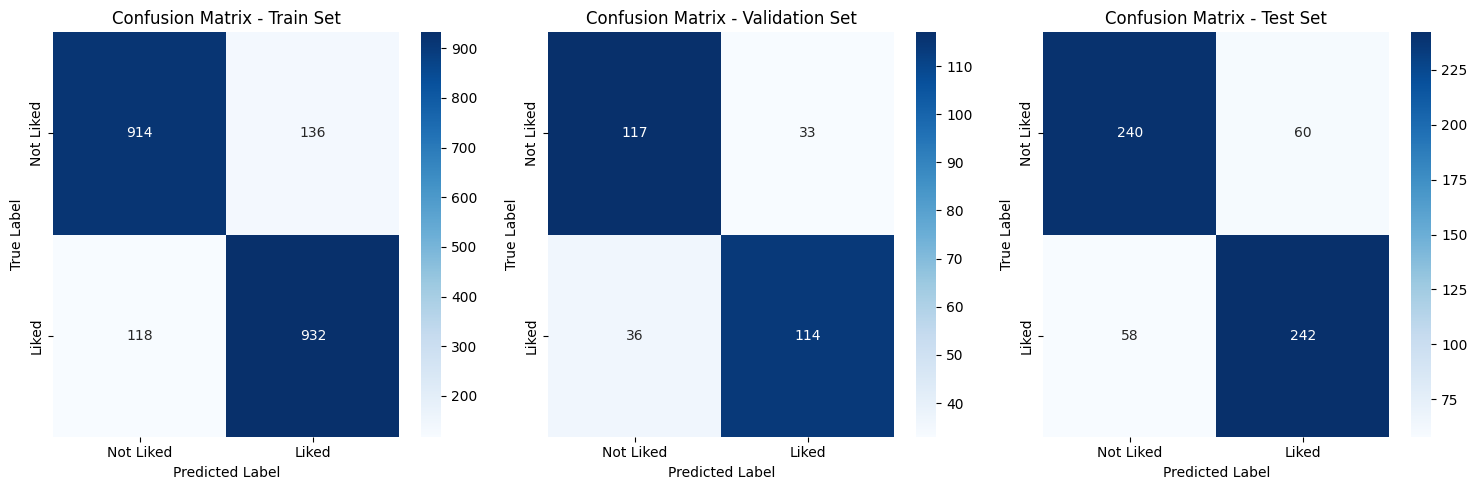


Analyzing Feature Importance:


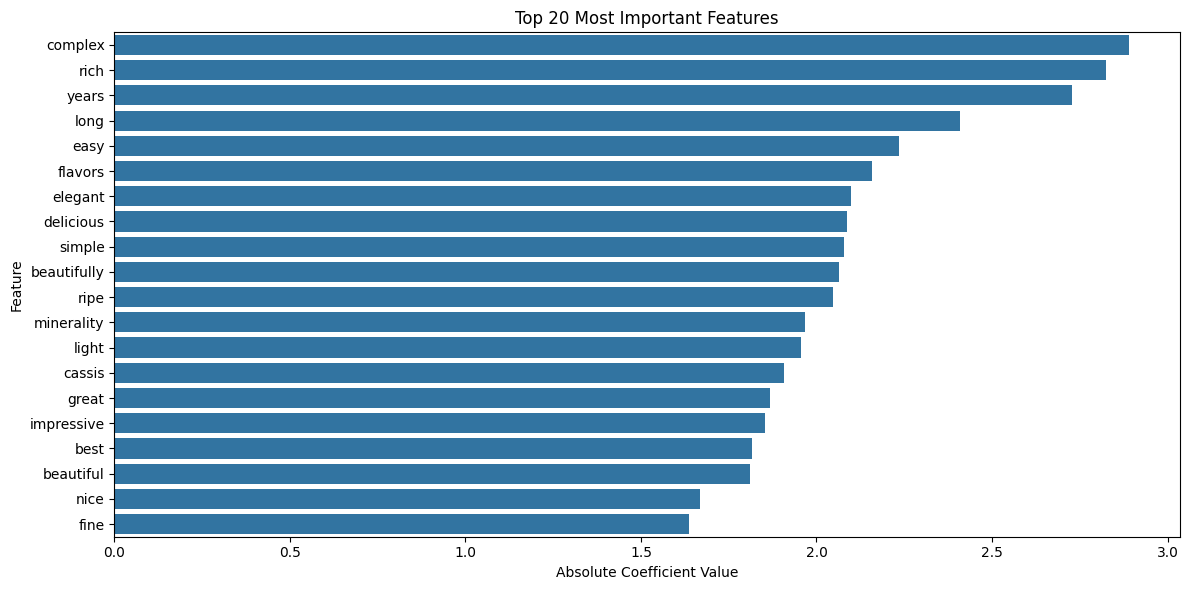


Example Predictions:

Review: An excellent wine with great balance and complexity. Rich flavors of dark fruit and oak.
Prediction: Liked
Probability: Positive=0.859, Negative=0.141

Review: Simple and straightforward. Somewhat bland with little character.
Prediction: Not Liked
Probability: Positive=0.049, Negative=0.951

Review: Amazing depth with perfect tannins. A masterpiece of winemaking.
Prediction: Not Liked
Probability: Positive=0.470, Negative=0.530


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

def load_and_prepare_data(file_path):
    df = pd.read_csv(file_path)

    df = df[['description', 'points']]

    df['sentiment'] = df['points'].apply(lambda x: 1 if x >= 90 else 0)

    df = df.drop('points', axis=1)

    df.columns = ['Review', 'Liked']

    return df

def preprocess_text(text):
    text = str(text)
    text = text.lower()
    return text

def create_baseline_model(df, val_size=0.1, test_size=0.2, random_state=42):
    df['Review'] = df['Review'].apply(preprocess_text)

    X = df['Review']
    y = df['Liked']

    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=val_size/(1-test_size),
        random_state=random_state, stratify=y_train_val
    )

    tfidf = TfidfVectorizer(
        max_features=1000,
        stop_words='english',
        lowercase=True,
        ngram_range=(1, 2)
    )

    X_train_tfidf = tfidf.fit_transform(X_train)
    X_val_tfidf = tfidf.transform(X_val)
    X_test_tfidf = tfidf.transform(X_test)

    model = LogisticRegression(random_state=random_state, max_iter=1000)
    model.fit(X_train_tfidf, y_train)

    return model, tfidf, X_train_tfidf, X_val_tfidf, X_test_tfidf, y_train, y_val, y_test, X_train, X_val, X_test

def evaluate_model(model, X_train_tfidf, X_val_tfidf, X_test_tfidf,
                   X_train, X_val, X_test,
                   y_train, y_val, y_test):
    datasets = [
        ('Train', X_train_tfidf, y_train),
        ('Validation', X_val_tfidf, y_val),
        ('Test', X_test_tfidf, y_test)
    ]

    plt.figure(figsize=(15, 5))

    classification_reports = {}

    for i, (name, X_tfidf, y_true) in enumerate(datasets, 1):
        y_pred = model.predict(X_tfidf)

        accuracy = accuracy_score(y_true, y_pred)
        print(f"{name} Accuracy: {accuracy:.4f}")

        class_report = classification_report(y_true, y_pred, output_dict=True)
        classification_reports[name] = class_report
        print(f"\nClassification Report ({name} Set):")
        print(classification_report(y_true, y_pred))

        plt.subplot(1, 3, i)
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Not Liked', 'Liked'],
                    yticklabels=['Not Liked', 'Liked'])
        plt.title(f'Confusion Matrix - {name} Set')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')

    plt.tight_layout()
    plt.show()

    return classification_reports

def analyze_features(model, tfidf):
    feature_importance = pd.DataFrame({
        'feature': tfidf.get_feature_names_out(),
        'importance': abs(model.coef_[0])
    })

    feature_importance = feature_importance.sort_values('importance', ascending=False)

    plt.figure(figsize=(12, 6))
    sns.barplot(data=feature_importance.head(20), x='importance', y='feature')
    plt.title('Top 20 Most Important Features')
    plt.xlabel('Absolute Coefficient Value')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

    return feature_importance

def predict_sentiment(model, tfidf, review_text):
    processed_text = preprocess_text(review_text)

    text_tfidf = tfidf.transform([processed_text])

    prediction = model.predict(text_tfidf)[0]
    probability = model.predict_proba(text_tfidf)[0]

    return prediction, probability

if __name__ == "__main__":
    file_path = "wine_small_balanced.csv"
    df = load_and_prepare_data(file_path)

    print("Dataset Shape:", df.shape)
    print("\nClass Distribution:")
    print(df['Liked'].value_counts(normalize=True))

    model, tfidf, X_train_tfidf, X_val_tfidf, X_test_tfidf, y_train, y_val, y_test, X_train, X_val, X_test = create_baseline_model(df)

    print("\nModel Evaluation:")
    classification_reports = evaluate_model(
        model,
        X_train_tfidf, X_val_tfidf, X_test_tfidf,
        X_train, X_val, X_test,
        y_train, y_val, y_test
    )

    print("\nAnalyzing Feature Importance:")
    feature_importance = analyze_features(model, tfidf)

    print("\nExample Predictions:")
    example_reviews = [
        "An excellent wine with great balance and complexity. Rich flavors of dark fruit and oak.",
        "Simple and straightforward. Somewhat bland with little character.",
        "Amazing depth with perfect tannins. A masterpiece of winemaking."
    ]

    for review in example_reviews:
        prediction, probability = predict_sentiment(model, tfidf, review)
        print(f"\nReview: {review}")
        print(f"Prediction: {'Liked' if prediction == 1 else 'Not Liked'}")
        print(f"Probability: Positive={probability[1]:.3f}, Negative={probability[0]:.3f}")

# **150k dataset**

Dataset Shape: (150930, 2)

Class Distribution:
Liked
0    0.68058
1    0.31942
Name: proportion, dtype: float64

Model Evaluation:
Train Accuracy: 0.8388

Classification Report (Train Set):
              precision    recall  f1-score   support

           0       0.86      0.91      0.88     71904
           1       0.78      0.69      0.73     33747

    accuracy                           0.84    105651
   macro avg       0.82      0.80      0.81    105651
weighted avg       0.84      0.84      0.84    105651

Validation Accuracy: 0.8334

Classification Report (Validation Set):
              precision    recall  f1-score   support

           0       0.86      0.90      0.88     10272
           1       0.77      0.68      0.72      4821

    accuracy                           0.83     15093
   macro avg       0.81      0.79      0.80     15093
weighted avg       0.83      0.83      0.83     15093

Test Accuracy: 0.8332

Classification Report (Test Set):
              precision    re

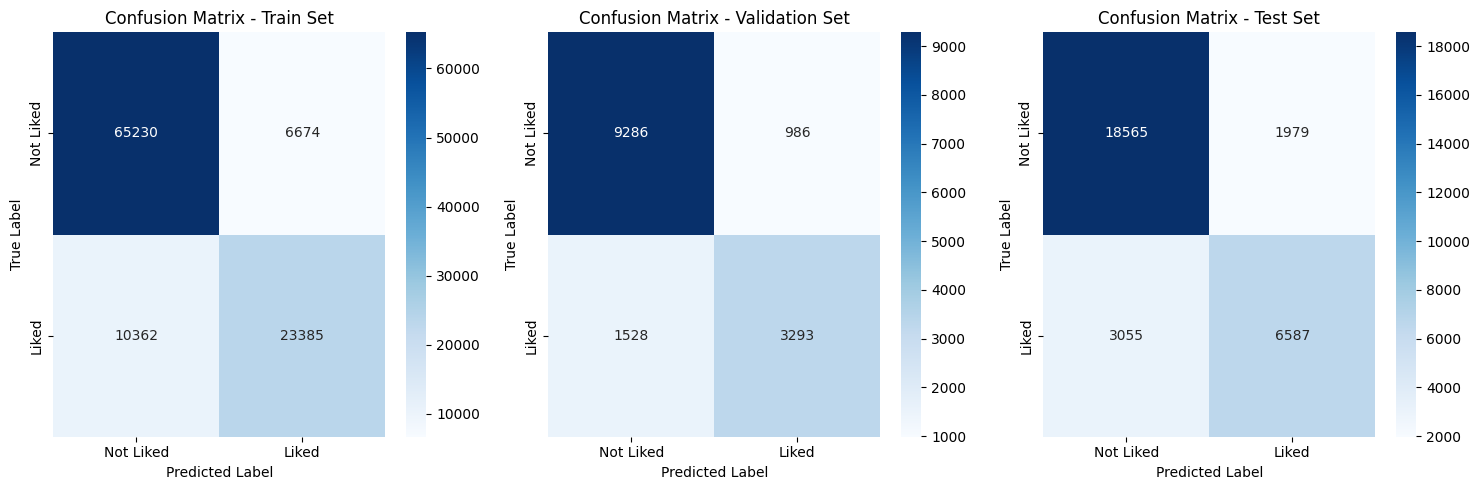


Analyzing Feature Importance:


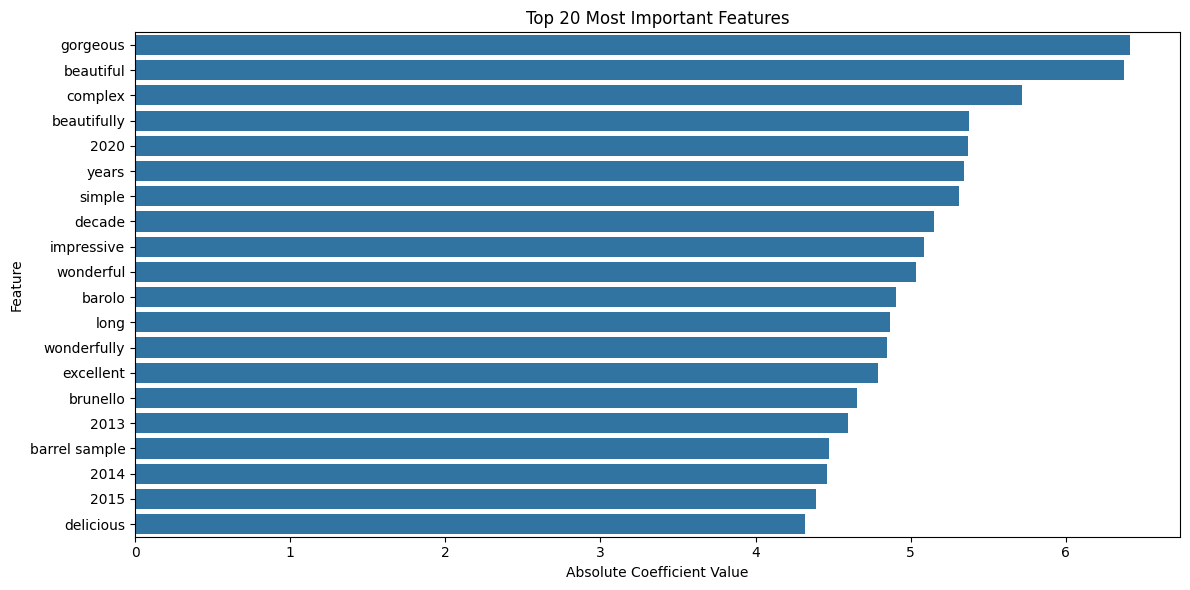


Example Predictions:

Review: An excellent wine with great balance and complexity. Rich flavors of dark fruit and oak.
Prediction: Liked
Probability: Positive=0.844, Negative=0.156

Review: Simple and straightforward. Somewhat bland with little character.
Prediction: Not Liked
Probability: Positive=0.000, Negative=1.000

Review: Amazing depth with perfect tannins. A masterpiece of winemaking.
Prediction: Not Liked
Probability: Positive=0.234, Negative=0.766


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

def load_and_prepare_data(file_path):
    df = pd.read_csv(file_path)

    df = df[['description', 'points']]

    df['sentiment'] = df['points'].apply(lambda x: 1 if x >= 90 else 0)

    df = df.drop('points', axis=1)

    df.columns = ['Review', 'Liked']

    return df

def preprocess_text(text):
    text = str(text)
    text = text.lower()
    return text

def create_baseline_model(df, val_size=0.1, test_size=0.2, random_state=42):
    df['Review'] = df['Review'].apply(preprocess_text)

    X = df['Review']
    y = df['Liked']

    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=val_size/(1-test_size),
        random_state=random_state, stratify=y_train_val
    )

    tfidf = TfidfVectorizer(
        max_features=1000,
        stop_words='english',
        lowercase=True,
        ngram_range=(1, 2)
    )

    X_train_tfidf = tfidf.fit_transform(X_train)
    X_val_tfidf = tfidf.transform(X_val)
    X_test_tfidf = tfidf.transform(X_test)

    model = LogisticRegression(random_state=random_state, max_iter=1000)
    model.fit(X_train_tfidf, y_train)

    return model, tfidf, X_train_tfidf, X_val_tfidf, X_test_tfidf, y_train, y_val, y_test, X_train, X_val, X_test

def evaluate_model(model, X_train_tfidf, X_val_tfidf, X_test_tfidf,
                   X_train, X_val, X_test,
                   y_train, y_val, y_test):
    datasets = [
        ('Train', X_train_tfidf, y_train),
        ('Validation', X_val_tfidf, y_val),
        ('Test', X_test_tfidf, y_test)
    ]

    plt.figure(figsize=(15, 5))

    classification_reports = {}

    for i, (name, X_tfidf, y_true) in enumerate(datasets, 1):
        y_pred = model.predict(X_tfidf)

        accuracy = accuracy_score(y_true, y_pred)
        print(f"{name} Accuracy: {accuracy:.4f}")

        class_report = classification_report(y_true, y_pred, output_dict=True)
        classification_reports[name] = class_report
        print(f"\nClassification Report ({name} Set):")
        print(classification_report(y_true, y_pred))

        plt.subplot(1, 3, i)
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Not Liked', 'Liked'],
                    yticklabels=['Not Liked', 'Liked'])
        plt.title(f'Confusion Matrix - {name} Set')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')

    plt.tight_layout()
    plt.show()

    return classification_reports

def analyze_features(model, tfidf):
    feature_importance = pd.DataFrame({
        'feature': tfidf.get_feature_names_out(),
        'importance': abs(model.coef_[0])
    })

    feature_importance = feature_importance.sort_values('importance', ascending=False)

    plt.figure(figsize=(12, 6))
    sns.barplot(data=feature_importance.head(20), x='importance', y='feature')
    plt.title('Top 20 Most Important Features')
    plt.xlabel('Absolute Coefficient Value')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

    return feature_importance

def predict_sentiment(model, tfidf, review_text):
    processed_text = preprocess_text(review_text)

    text_tfidf = tfidf.transform([processed_text])

    prediction = model.predict(text_tfidf)[0]
    probability = model.predict_proba(text_tfidf)[0]

    return prediction, probability

if __name__ == "__main__":
    file_path = "winemag-data_first150k.csv"
    df = load_and_prepare_data(file_path)

    print("Dataset Shape:", df.shape)
    print("\nClass Distribution:")
    print(df['Liked'].value_counts(normalize=True))

    model, tfidf, X_train_tfidf, X_val_tfidf, X_test_tfidf, y_train, y_val, y_test, X_train, X_val, X_test = create_baseline_model(df)

    print("\nModel Evaluation:")
    classification_reports = evaluate_model(
        model,
        X_train_tfidf, X_val_tfidf, X_test_tfidf,
        X_train, X_val, X_test,
        y_train, y_val, y_test
    )

    print("\nAnalyzing Feature Importance:")
    feature_importance = analyze_features(model, tfidf)

    print("\nExample Predictions:")
    example_reviews = [
        "An excellent wine with great balance and complexity. Rich flavors of dark fruit and oak.",
        "Simple and straightforward. Somewhat bland with little character.",
        "Amazing depth with perfect tannins. A masterpiece of winemaking."
    ]

    for review in example_reviews:
        prediction, probability = predict_sentiment(model, tfidf, review)
        print(f"\nReview: {review}")
        print(f"Prediction: {'Liked' if prediction == 1 else 'Not Liked'}")
        print(f"Probability: Positive={probability[1]:.3f}, Negative={probability[0]:.3f}")

TypeError: bar() missing 2 required positional arguments: 'x' and 'height'

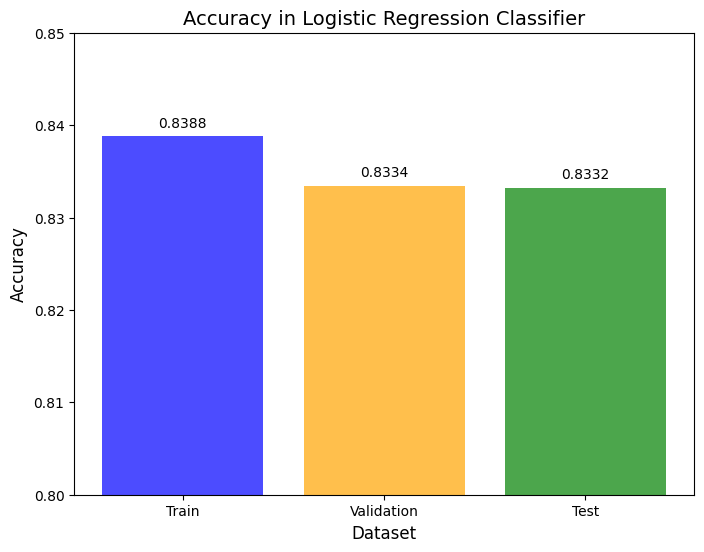

In [4]:
import matplotlib.pyplot as plt

categories = ['Train', 'Validation', 'Test']
accuracy = [0.8388, 0.8334, 0.8332]

plt.figure(figsize=(8, 6))
plt.bar(categories, accuracy, color=['blue', 'orange', 'green'], alpha=0.7)

plt.xlabel('Dataset', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Accuracy in Logistic Regression Classifier', fontsize=14)

for i, val in enumerate(accuracy):
    plt.text(i, val + 0.001, f'{val:.4f}', ha='center', fontsize=10)

plt.ylim(0.8, 0.85)
plt.bar(axis='y', alpha=0.6)
plt.show()

In [ ]:
import matplotlib.pyplot as plt

categories = ['Train', 'Validation', 'Test']
accuracy = [0.50, 0.50, 0.50]

plt.figure(figsize=(8, 6))
plt.bar(categories, accuracy, color=['blue', 'orange', 'green'], alpha=0.7)

plt.xlabel('Dataset', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Accuracy in DistilBERT', fontsize=14)

for i, val in enumerate(accuracy):
    plt.text(i, val + 0.001, f'{val:.4f}', ha='center', fontsize=10)

# plt.ylim(0.8, 0.85)
# plt.bar(axis='y', alpha=0.6)
# plt.show()

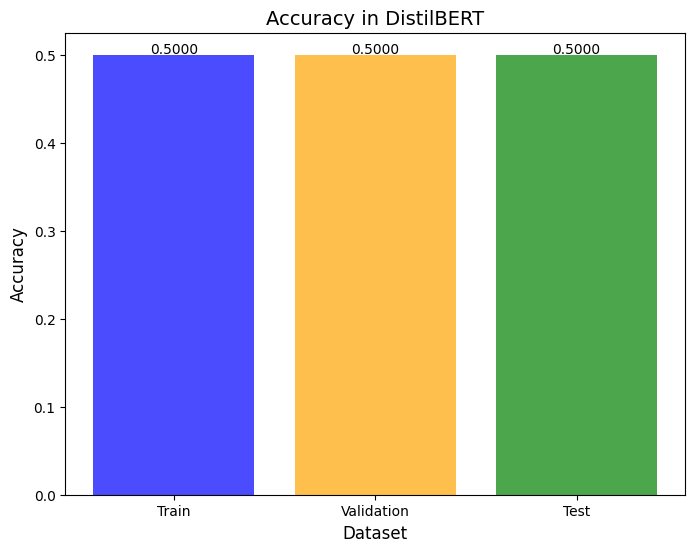

In [6]:
import matplotlib.pyplot as plt

categories = ['Train', 'Validation', 'Test']
accuracy = [0.50, 0.50, 0.50]

plt.figure(figsize=(8, 6))
plt.bar(categories, accuracy, color=['blue', 'orange', 'green'], alpha=0.7)

plt.xlabel('Dataset', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Accuracy in DistilBERT', fontsize=14)

for i, val in enumerate(accuracy):
    plt.text(i, val + 0.001, f'{val:.4f}', ha='center', fontsize=10)

# plt.ylim(0.8, 0.85)
# plt.bar(axis='y', alpha=0.6)

plt.show()

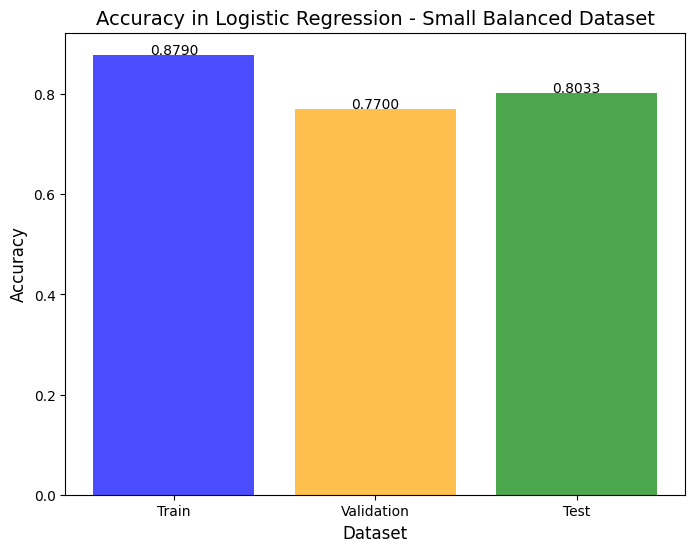

In [8]:
import matplotlib.pyplot as plt

categories = ['Train', 'Validation', 'Test']
accuracy = [0.8790, 0.7700, 0.8033]

plt.figure(figsize=(8, 6))
plt.bar(categories, accuracy, color=['blue', 'orange', 'green'], alpha=0.7)

plt.xlabel('Dataset', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Accuracy in Logistic Regression - Small Balanced Dataset', fontsize=14)

for i, val in enumerate(accuracy):
    plt.text(i, val + 0.001, f'{val:.4f}', ha='center', fontsize=10)

# plt.ylim(0.8, 0.85)
# plt.bar(axis='y', alpha=0.6)
plt.show()